In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



image.shape: torch.Size([1, 28, 28])
Label: 5


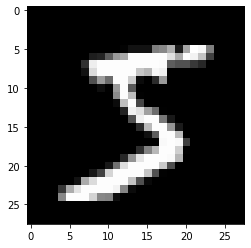

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


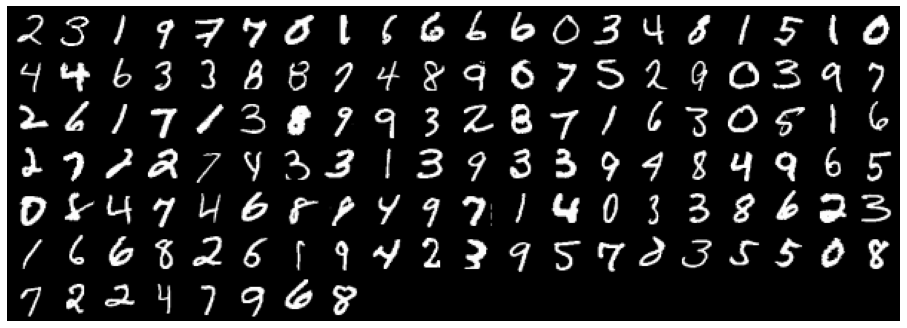

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=20).permute((1, 2, 0)))
    break

# create layer

flatten the 1x28x28 images into vectors of size 784, so they can be passed into an nn.Linear object.

In [7]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


let's create a nn.Linear object, which will serve as our hidden layer.

input size: 784, output size 32. linear layer  

In [8]:
input_size = inputs.shape[-1]
hidden_size = 32
layer1 = nn.Linear(input_size, hidden_size)

In [9]:
print(inputs.shape)
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

torch.Size([128, 784])
layer1_outputs.shape: torch.Size([128, 32])


input size:32, output size: 32.  RElu *layer*

In [10]:
relu_outputs = F.relu(layer1_outputs)


input size:32, output size: 10.  linear *layer*



In [11]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

# Model

In [71]:
class MnistModel(nn.Module):
    def __init__(self,in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear1(xb)
        out= F.relu(out)
        out=self.linear2(out)
        return out

    def training_step(self,batch):
        images, labels=batch
        out=self(images)
        loss=F.cross_entropy(out, labels)
        return loss

    def validation_step(self,batch):
        images, labels = batch
        out=self(images)
        loss=F.cross_entropy(out, labels)
        acc=accuracy(out, labels)
        return loss, acc

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
input_size = 784
hid_size = 32 # you can change this
num_classes = 10
model = MnistModel(in_size=input_size, hidden_size=hid_size, out_size=num_classes)


# Use GPU

In [27]:
torch.cuda.is_available()


True

In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [29]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [30]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cuda:0


In [31]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [33]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


xb.device: cuda:0
yb: tensor([4, 1, 1, 5, 3, 3, 5, 4, 1, 4, 5, 3, 1, 4, 2, 5, 3, 6, 4, 3, 4, 4, 1, 6,
        7, 7, 1, 9, 3, 2, 8, 8, 0, 8, 0, 6, 6, 1, 9, 4, 0, 8, 6, 2, 5, 9, 6, 7,
        1, 7, 7, 1, 9, 3, 6, 9, 7, 3, 5, 3, 7, 3, 0, 9, 9, 2, 0, 5, 8, 3, 5, 9,
        5, 0, 0, 6, 5, 6, 6, 4, 9, 8, 1, 7, 2, 9, 3, 7, 8, 0, 4, 7, 8, 6, 1, 2,
        7, 1, 4, 9, 8, 8, 9, 4, 1, 0, 7, 9, 2, 9, 9, 4, 3, 1, 2, 1, 4, 1, 2, 2,
        5, 0, 9, 9, 3, 8, 1, 8, 7, 9, 8, 9, 0, 2, 7, 7, 2, 6, 5, 5, 1, 6, 5, 3,
        1, 1, 1, 5, 4, 3, 5, 8, 9, 6, 9, 3, 3, 9, 9, 6, 1, 4, 4, 0, 9, 3, 9, 8,
        8, 6, 1, 5, 3, 1, 6, 2, 8, 7, 2, 7, 3, 4, 3, 7, 0, 6, 9, 9, 4, 2, 9, 8,
        6, 5, 2, 6, 5, 1, 4, 3, 0, 8, 5, 1, 2, 2, 4, 1, 3, 8, 2, 6, 3, 1, 4, 3,
        3, 8, 6, 8, 2, 9, 9, 7, 4, 9, 1, 1, 4, 1, 3, 9, 2, 1, 9, 0, 9, 9, 5, 0,
        1, 7, 6, 2, 0, 4, 0, 6, 9, 3, 7, 0, 3, 4, 4, 6], device='cuda:0')


# Train the model

In [39]:
def fit(epochs, step_size, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), step_size) #lr: stepsize
    loss_epoch_res=[]
    acc_epoch_res=[]
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        loss_result=[]
        accuracy_result=[]
        for batch in val_loader:
            loss, acc=model.validation_step(batch)
            loss_result.append(loss)
            accuracy_result.append(acc)

        avg_loss=sum(loss_result)/len(loss_result)
        avg_acc=sum(accuracy_result)/len(accuracy_result)
        loss_epoch_res.append(avg_loss)
        acc_epoch_res.append(avg_acc)
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, avg_loss, avg_acc))
    return loss_epoch_res,acc_epoch_res

In [74]:
input_size = 784
hid_size = 32 # you can change this
num_classes = 10
model = MnistModel(in_size=input_size, hidden_size=hid_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [41]:
acc_final_res=[]
result1=fit(5, 0.001, model, train_loader, val_loader)
loss,acc=result1
for item in acc:
  acc_final_res.append(item)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.2592, val_acc: 0.1484
Epoch [1], val_loss: 2.1830, val_acc: 0.3414
Epoch [2], val_loss: 2.0891, val_acc: 0.5471
Epoch [3], val_loss: 1.9826, val_acc: 0.6255
Epoch [4], val_loss: 1.8671, val_acc: 0.6664


In [42]:
loss_final_res=[]
for item in loss:
  loss_final_res.append(item)

In [43]:
result2=fit(5, 0.001, model, train_loader, val_loader)
loss,acc=result2
for item in acc:
  acc_final_res.append(item)
for item in loss:
  loss_final_res.append(item)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.7455, val_acc: 0.6869
Epoch [1], val_loss: 1.6213, val_acc: 0.7103
Epoch [2], val_loss: 1.4986, val_acc: 0.7286
Epoch [3], val_loss: 1.3814, val_acc: 0.7426
Epoch [4], val_loss: 1.2731, val_acc: 0.7564


In [44]:
result3=fit(5, 0.001, model, train_loader, val_loader)
loss,acc=result3
for item in acc:
  acc_final_res.append(item)
for item in loss:
  loss_final_res.append(item)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.1757, val_acc: 0.7696
Epoch [1], val_loss: 1.0900, val_acc: 0.7843
Epoch [2], val_loss: 1.0156, val_acc: 0.7970
Epoch [3], val_loss: 0.9513, val_acc: 0.8069
Epoch [4], val_loss: 0.8959, val_acc: 0.8158


In [45]:
result4=fit(5, 0.001, model, train_loader, val_loader)
loss,acc=result4
for item in acc:
  acc_final_res.append(item)
for item in loss:
  loss_final_res.append(item)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.8479, val_acc: 0.8234
Epoch [1], val_loss: 0.8064, val_acc: 0.8280
Epoch [2], val_loss: 0.7702, val_acc: 0.8339
Epoch [3], val_loss: 0.7383, val_acc: 0.8374
Epoch [4], val_loss: 0.7101, val_acc: 0.8408


In [46]:
result5=fit(10, 0.001, model, train_loader, val_loader)
loss,acc=result5
for item in acc:
  acc_final_res.append(item)
for item in loss:
  loss_final_res.append(item)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.6850, val_acc: 0.8450
Epoch [1], val_loss: 0.6627, val_acc: 0.8476
Epoch [2], val_loss: 0.6424, val_acc: 0.8506
Epoch [3], val_loss: 0.6242, val_acc: 0.8510
Epoch [4], val_loss: 0.6076, val_acc: 0.8541
Epoch [5], val_loss: 0.5925, val_acc: 0.8555
Epoch [6], val_loss: 0.5786, val_acc: 0.8568
Epoch [7], val_loss: 0.5659, val_acc: 0.8589
Epoch [8], val_loss: 0.5542, val_acc: 0.8611
Epoch [9], val_loss: 0.5432, val_acc: 0.8644


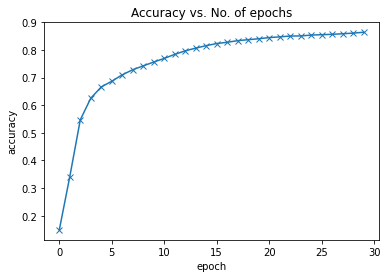

In [47]:
plt.plot(acc_final_res, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

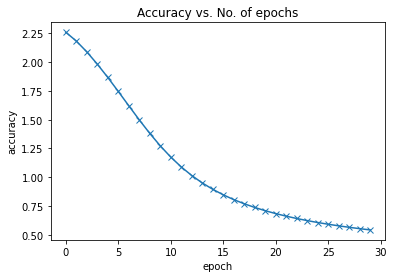

In [48]:
plt.plot(loss_final_res, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Predictiom

In [49]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [50]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


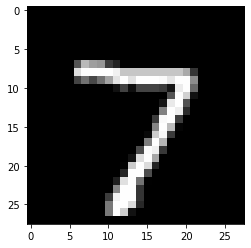

In [51]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


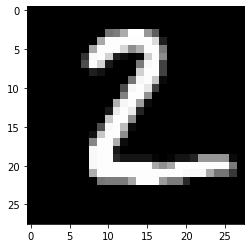

In [52]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))